In [1]:
# Import external toolboxes, functions
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba, LinearSegmentedColormap

from scipy.stats import sem, wilcoxon, mode, mannwhitneyu, kruskal, chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pycircstat import vtest

In [2]:
# Import custom functions
from parameters import *  # all-caps variables come from here
from util import *
from hht import HHT

### Define some plotting functions

### Figure 1B
Example traces of pupil size, run speed, and spike counts.

In [3]:
# Load pupil size, run speed, and neural data
conditions = ['spontaneous', 'sparsenoise']  # gray screen and sparse noise experiments
df_pupil = load_data('pupil', conditions)
df_run = load_data('ball', conditions)
df_spikes = load_data('spikes', conditions)
df_spikes = filter_units(df_spikes, MINRATE)  # remove units with min. rate less than threshold 
df = pd.merge(pd.merge(df_pupil, df_run), df_spikes).set_index(['m', 's', 'e', 'u'])  # merge into one big dataframe

Loading:  pupil_spontaneous.pkl
Loading:  pupil_sparsenoise.pkl
Loading:  ball_spontaneous.pkl
Loading:  ball_sparsenoise.pkl
Loading:  spikes_spontaneous.pkl
Loading:  spikes_sparsenoise.pkl


In [4]:
# Specify example mouse, experiment, and neuron using a 'key'
idx = key2idx(FIG1BEXAMPLEKEY)
t0, t1 = FIG1BEXAMPLETRANGE

# Fetch experiment data from dataframe
pupil_area = df.loc[idx]['pupil_area']
pupil_tpts = df.loc[idx]['pupil_tpts']
run_speed = df.loc[idx]['run_speed']
run_tpts = df.loc[idx]['run_tpts']

# Fetch spikes and convert to binned spike rates
spk_times = df.loc[idx]['spk_times']
tbins = np.arange(t0, t1, FIG1BTBINWIDTH)  # time bins
spk_rates = np.histogram(spk_times, bins=tbins)[0] / FIG1BTBINWIDTH
spk_tpts = tbins[:-1] + FIG1BTBINWIDTH / 2

# Fetch burst times and restirct to time range
burst_times = df.loc[idx]['burst_times']
burst_times = burst_times[(burst_times >= t0) & (burst_times <= t1)]

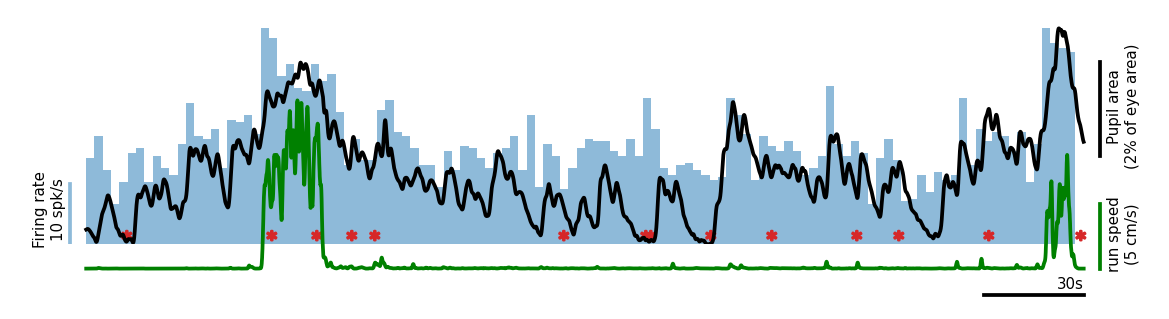

In [5]:
fig, axs = plt.subplots(2, sharex=True)

# Firing rates
axs[0].bar(spk_tpts, spk_rates, width=FIG1BTBINWIDTH, color=COLORS['tonicspk'], alpha=0.5)
axs[0].scatter(burst_times, np.ones_like(burst_times), color=COLORS['burst'], marker='$*$')

# Remove axes and add scale bar
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[0].plot([t0 - 5, t0 - 5], [0, 10], color=COLORS['tonicspk'], alpha=0.5)
axs[0].text(t0 - 11, 0, 'Firing rate\n10 spk/s', rotation=90, ha='center', fontsize=LABELFONTSIZE)

# Pupil size data
ax_pupil = axs[0].twinx()
i0, i1 = pupil_tpts.searchsorted([t0, t1])
ax_pupil.plot(pupil_tpts[i0:i1], pupil_area[i0:i1], color=COLORS['pupil'])

# Remove axes and add scale bar
ax_pupil.xaxis.set_visible(False)
ax_pupil.yaxis.set_visible(False)
ax_pupil.plot([t1 + 5, t1 + 5], [0.03, 0.05], color=COLORS['pupil'])
ax_pupil.text(t1 + 12, 0.028, 'Pupil area\n(2% of eye area)', fontsize=LABELFONTSIZE, ha='center', rotation=90)
ax_pupil.set_ylim(bottom=pupil_area.min())

# Run speed data
i0, i1 = run_tpts.searchsorted([t0, t1])
axs[1].plot(run_tpts[i0:i1], run_speed[i0:i1], color=COLORS['run'])

# Remove axes and add scale bar
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[1].plot([t1 + 5, t1 + 5], [0, 5], color=COLORS['run'])
axs[1].text(t1 + 12, 0, 'run speed\n(5 cm/s)', fontsize=LABELFONTSIZE, ha='center', rotation=90)
axs[1].set_ylim(bottom=-2.5, top=15)

# Remove all axis lines
for ax in list(axs) + [ax_pupil]:
    ax.set_frame_on(False)
    
# Time scale bar
tbar_length = 30
t0_tbar = t1 - tbar_length
axs[1].plot([t0_tbar, t1], [-2, -2], c='k', lw=1.5)
axs[1].text(t1 - 8, -1.5, '%ds' % tbar_length, fontsize=LABELFONTSIZE)
    
# Adjust spacing and size
fig.subplots_adjust(hspace=-0.75)
set_plotsize(w=16, h=4)

fig.savefig(FIGUREPATH + 'example_traces' + FIGSAVEFORMAT)

### Figure 1C
Modulation of firing rates by pupil size.

Loading:  sizetuning_spontaneous_spk.pkl
Loading:  sizetuning_sparsenoise_spk.pkl
Monotonic increasing: 62/140 (44.3)


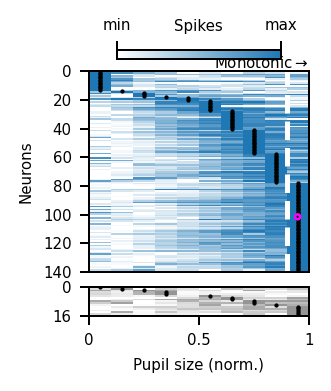

In [3]:
# Load pupil size tuning data for tonic spikes from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df = load_data('sizetuning', conditions, spk_type='spk').set_index(['m', 's', 'e', 'u'])  # 'spk' = all spikes

# Get graded colormap for tonic spikes
toniccmap = LinearSegmentedColormap.from_list("toniccmap", ['white', np.array(to_rgba(COLORS['tonicspk']))])
# Plot rate heatmap with example
fig = pupil_area_rate_heatmap(df, toniccmap, max_rate='high', example=FIG1BEXAMPLEKEY)

set_plotsize(w=3, h=4)
fig.savefig(FIGUREPATH + 'pupil_size_spk_tuning' + FIGSAVEFORMAT)

Loading:  sizetuning_spontaneous_burst.pkl
Loading:  sizetuning_sparsenoise_burst.pkl
Monotonic decreasing: 72/93 (77.4)


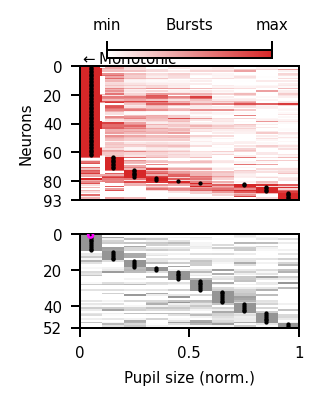

In [4]:
# Load pupil size tuning data for bursts from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df = load_data('sizetuning', conditions, spk_type='burst').set_index(['m', 's', 'e', 'u'])

# Get graded colormap for tonic spikes
burstcmap = LinearSegmentedColormap.from_list("burstcmap", ['white', np.array(to_rgba(COLORS['burst']))])
# Plot rate heatmap with example
fig = pupil_area_rate_heatmap(df, burstcmap, max_rate='low', example=FIG1BEXAMPLEKEY)
# Change label from 'Spikes' to 'Bursts'
fig.axes[1].set_xlabel('Bursts')

set_plotsize(w=3, h=4)
fig.savefig(FIGUREPATH + 'pupil_size_burst_tuning' + FIGSAVEFORMAT)

### Figure 1D1
Components of pupil dynamics (CPDs) resulting from applying empirical mode decomposition (EMD) to the example pupil size trace. Note that the technical term for CPD is intrinsic mode function (IMF).

In [8]:
# Load pupil data from gray screen and sparsenoise experiments
conditions = ['spontaneous', 'sparsenoise']
df_pupil = load_data('pupil', conditions).set_index(['m', 's', 'e'])

Loading:  pupil_spontaneous.pkl
Loading:  pupil_sparsenoise.pkl


In [9]:
# Get data for example experiment
key = FIG1DEXAMPLEKEY
pupil_area = df_pupil.loc[key2idx(key)]['pupil_area']
pupil_tpts = df_pupil.loc[key2idx(key)]['pupil_tpts']
pupil_fs = 1 / np.diff(pupil_tpts).mean()

# Apply Hilbert-Huang transform to example pupil size trace
hht = HHT(pupil_area, pupil_fs)  # instantiate transform object
hht.emd()  # empirical mode decomposition
hht.hsa()  # Hilbert spectral analysis

# Extract example time range (same as Figure 1B)
t0, t1 = FIG1BEXAMPLETRANGE
i0, i1 = pupil_tpts.searchsorted([t0, t1])
pupil_area_ex = pupil_area[i0:i1]
pupil_tpts_ex = pupil_tpts[i0:i1]
imfs_ex = hht.imfs[i0:i1].T  # transpose to get IMFs as rows

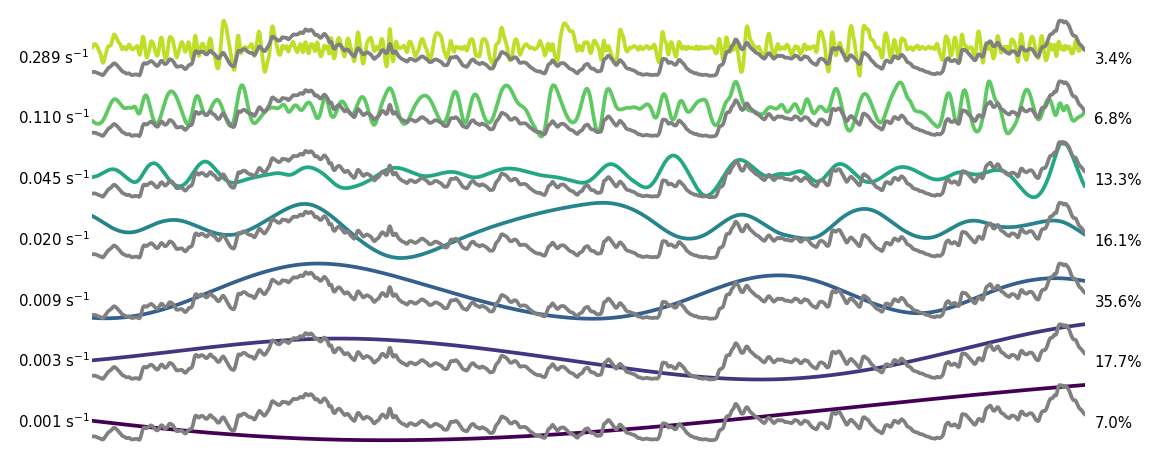

In [10]:
fig, axs = plt.subplots(len(imfs_ex), sharex=True)

# Create a color space and sample from it for each IMF
color_vals = 1 - np.linspace(0.1, 1, len(imfs_ex))
imf_cmap = COLORS['imfs']
imfcolors = imf_cmap(color_vals)

# Plot each IMF
for i, (ax, imf) in enumerate(zip(axs, imfs_ex)):
    ax.plot(pupil_tpts_ex, imf, color=imfcolors[i])

    # Remove axes and ticks
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot pupil area in gray on its own y-axis
    ax_pupil = ax.twinx()
    ax_pupil.plot(pupil_tpts_ex, pupil_area_ex, color='gray', zorder=-1)
    ax_pupil.set_frame_on(False)
    ax_pupil.set_xticks([])
    ax_pupil.set_yticks([])
    
    # Restrict x-axis to example time range
    ax.set_xlim([t0, t1])
    ax_pupil.set_xlim([t0, t1])
    
    # Add label for IMF characteristic frequency
    freq = hht.characteristic_frequency[i]
    ax.text(-0.075, 0.25, '%.3f s$^{-1}$' % freq, fontsize=LABELFONTSIZE, transform=ax.transAxes)
    
    # Add label for IMF power (expressed as % total)
    power = hht.power_ratio[i] * 100
    ax.text(1.01, 0.25, '%.1f%s' % (power, '%'), fontsize=LABELFONTSIZE, transform=ax.transAxes)

# Adjust vertical space between subplots
fig.subplots_adjust(hspace=0)

set_plotsize(w=14, h=6)
fig.savefig(FIGUREPATH + 'imfs' + FIGSAVEFORMAT)

### Figure 1D2
Illustration of the analytic signal components for example IMF.

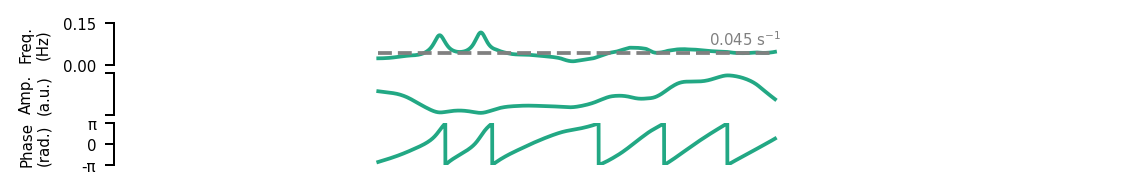

In [11]:
# Set and example IMF
imfi = FIG1DEXAMPLEIMF
characteristic_frequency = hht.characteristic_frequency[imfi]
color = imfcolors[imfi]

# Only show for a few cycles of the example IMF
t0, t1 = 300, 420
i0, i1 = pupil_tpts.searchsorted([t0, t1])

# Get instantaneous phase, frequency, and amplitude
phase = hht.phase[i0:i1, imfi]
freq = hht.frequency[i0:i1, imfi]
amplitude = hht.amplitude[i0:i1, imfi]

# Set up axes
fig, axs = plt.subplots(3, sharex=True)

# Plot phase
axs[2].plot(pupil_tpts[i0:i1], phase, color=color)
axs[2].set_ylim([-np.pi, np.pi])
axs[2].set_yticks([-np.pi, 0, np.pi])
axs[2].set_yticklabels(['-'+u'\u03C0', r'0', u'\u03C0'])
axs[2].set_ylabel('Phase\n(rad.)', rotation=90, labelpad=12)

# Plot frequency
axs[0].plot(pupil_tpts[i0:i1], freq, color=color)
axs[0].plot([t0, t1], [characteristic_frequency, characteristic_frequency], ls='--', color='gray')
axs[0].text(t1 - 20, characteristic_frequency + 0.025, '%.3f s$^{-1}$' % characteristic_frequency, color='gray', fontsize=LABELFONTSIZE)
axs[0].set_ylim([0, 0.15])
axs[0].set_yticks([0, 0.15])
axs[0].set_ylabel('Freq.\n(Hz)', rotation=90, labelpad=5)

# Plot amplitude
axs[1].plot(pupil_tpts[i0:i1], amplitude, color=color)
axs[1].set_ylim([amplitude.min(), amplitude.max()])
axs[1].set_yticks([amplitude.min() - 0.0005, amplitude.max() + 0.0005])
axs[1].set_yticklabels([])
axs[1].set_ylabel('Amp.\n(a.u.)', rotation=90, labelpad=18)

# Remove axis lines
for ax in axs:
    ax.set_xticks([pupil_tpts[i0:i1].min(), pupil_tpts[i0:i1].max()])
    ax.xaxis.set_visible(False)
    ax.set_xlim([220, 520])
    clip_axes_to_ticks(ax=ax, spines=['left'])
    ax.spines['bottom'].set_visible(False)
    
set_plotsize(w=14, h=2)
fig.savefig(FIGUREPATH + 'hsa' + FIGSAVEFORMAT)

### Figure 1D3
Frequency-power scatter plot for all extracted CPDs. Components from example decomposition are plotted with color.

In [12]:
# Load HHT data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df_hht = load_data('hht', conditions).set_index(['m', 's', 'e'])

# Get frequency and power values for all IMFs
freq = np.concatenate([row['frequency'] for idx, row in df_hht.iterrows()])
power = np.concatenate([row['power'] for idx, row in df_hht.iterrows()])

# Get frequency with peak power from each decomposition
peak_freq = df_hht.apply(lambda x: x['frequency'][x['power'].argmax()], axis='columns')

# Get frequency and power values for the example
key = FIG1DEXAMPLEKEY
freq_ex = df_hht.loc[key2idx(key)]['frequency']
power_ex = df_hht.loc[key2idx(key)]['power']

# Log-transform all frequency values
freq = np.log10(freq)
peak_freq = np.log10(peak_freq)
freq_ex = np.log10(freq_ex)

Loading:  hht_spontaneous.pkl
Loading:  hht_sparsenoise.pkl


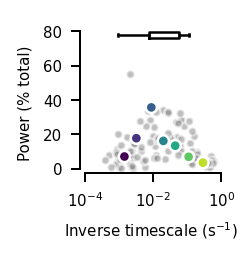

In [13]:
# Plot IMF frequency versus power
fig, ax = plt.subplots()

# Scatter plot all IMFs
ax.scatter(freq, power, fc='gray', ec='white', alpha=0.5, s=10)

# Plot data from example decomposition
color_vals = 1 - np.linspace(0.1, 1, len(freq_ex))  # sample from color space for example IMFs
imf_cmap = COLORS['imfs']
imfcolors = imf_cmap(color_vals)
ax.scatter(freq_ex, power_ex, fc=imfcolors, ec='white', s=20)

# Set x-axis ticks and labels
xticks = np.arange(-4, 2, 2, dtype='float')
xticklabels = ['$10^{%d}$' % tick for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlim(left=-4.15, right=0)
ax.set_xlabel('Inverse timescale (s$^{-1}$)')

# Set y-axis ticks and labels
yticks = np.arange(0, 1, .2)
yticklabels = [int(100 * tick) for tick in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Power (% total)')

# Illustrate distribution of frequencies of IMFs with highest power with boxplot
ax_freq = ax.inset_axes([0, 0.85, 1, .25])
ax_freq.boxplot(peak_freq, vert=False, usermedians=[np.nan], showfliers=False)

# Clean up inset axis
ax_freq.set_xticks(xticks)
ax_freq.xaxis.set_visible(False)
ax_freq.set_xlim(left=-4.15, right=0)
ax_freq.yaxis.set_visible(False)
ax_freq.set_frame_on(False)

clip_axes_to_ticks(ax)
fig.subplots_adjust(top=0.75, right=0.75)
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'imfpower' + FIGSAVEFORMAT)

### Figure 2B
Plot example component of pupil dynamic together with its phase, and burst and tonic spiking.

In [3]:
# Load spike and pupil data for gray screen and sparsenoise experiments
conditions = ['spontaneous', 'sparsenoise']
df_pupil = load_data('pupil', conditions)
df_spikes = load_data('spikes', conditions)
df = pd.merge(df_pupil, df_spikes, on=['m', 's', 'e']).set_index(['m', 's', 'e', 'u'])

# Load phase coupling data for gray screen and sparse noise experiments
df_coupling = load_data('phasetuning', conditions).set_index(['m', 's', 'e', 'u', 'imf'])

Loading:  pupil_spontaneous.pkl
Loading:  pupil_sparsenoise.pkl
Loading:  spikes_spontaneous.pkl
Loading:  spikes_sparsenoise.pkl
Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl


In [4]:
# Get example experiment
idx = key2idx(FIG2BEXAMPLEKEY)

# Get pupil size data for example experiment
pupil_area = df.loc[idx]['pupil_area']
pupil_tpts = df.loc[idx]['pupil_tpts']
pupil_fs = 1 / np.diff(pupil_tpts).mean()

# Apply Hilbert-Huang transform to example pupil size trace
hht = HHT(pupil_area, pupil_fs)
hht.emd()
hht.hsa()

# Get color for example CPD
imfcolors = hht.get_imf_colors(cmap=COLORS['imfs'])
imfcolor = imfcolors[FIG2BEXAMPLEIMF]

# Get time range to plot
t0, t1 = FIG2BEXAMPLETRANGE
t1 += 30
i0, i1 = pupil_tpts.searchsorted([t0, t1])

# Get tonic spike and burst times
spk_times = df.loc[idx]['tonicspk_times']
spk_times = spk_times[(spk_times > t0) & (spk_times < t1)]
burst_times = df.loc[idx]['burst_times']
burst_times = burst_times[(burst_times > t0) & (burst_times < t1)]

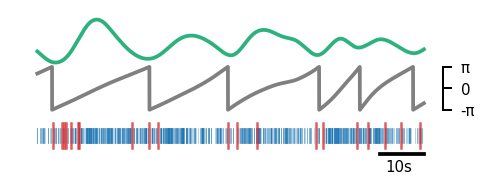

In [6]:
fig, axs = plt.subplots(3)

# Plot the CPD and its phase
axs[0].plot(pupil_tpts[i0:i1], hht.imfs[i0:i1, FIG2BEXAMPLEIMF], color=imfcolor)
axs[1].plot(pupil_tpts[i0:i1], hht.phase[i0:i1, FIG2BEXAMPLEIMF], color='gray')

# Plot tonic spikes and bursts
for spk in spk_times:
    axs[2].plot([spk, spk], [0.25, 0.75], lw=0.25, color=COLORS['tonicspk'], alpha=0.5)
for spk in burst_times:
    axs[2].plot([spk, spk], [0.1, 0.9], lw=1, color=COLORS['burst'], alpha=0.75)
axs[2].set_ylim(bottom=-0.25, top=1.25)

# Add scale bar for time
axs[2].plot([t1, t1 - 10], [-0.1, -0.1], color='black')
axs[2].text(0.865, -0.25, '10s', fontsize=LABELFONTSIZE, transform=axs[2].transAxes)

# Remove axes and ticks
for ax in [axs[0], axs[2]]:
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

# Format axes
axs[1].xaxis.set_visible(False)
axs[1].yaxis.tick_right()
axs[1].set_yticks([-np.pi, 0, np.pi])
axs[1].set_yticklabels((['-\u03C0', '0', '\u03C0']))

clip_axes_to_ticks(ax=axs[1], spines=['right'])
fig.subplots_adjust(hspace=0)
set_plotsize(w=6, h=2)
fig.savefig(FIGUREPATH + 'phase_coupling_schematic' + FIGSAVEFORMAT)

Plot the phase coupling of the example neuron and CPD.

In [7]:
# Get tonic spike and burst phases
spk_times = df.loc[idx]['tonicspk_times']
burst_times = df.loc[idx]['burst_times']
spk_is = pupil_tpts.searchsorted(spk_times)  # spike indices
burst_is = pupil_tpts.searchsorted(burst_times)
tonic_phases = hht.phase[:, FIG2BEXAMPLEIMF][spk_is]  # phase at spike indices
burst_phases = hht.phase[:, FIG2BEXAMPLEIMF][burst_is]

# Get phase coupling data for example neuron
idx_imf = idx + tuple([FIG2BEXAMPLEIMF + 1])  # add IMF to index
tonicspk_phase = df_coupling.loc[idx_imf, 'tonicspk_phase']  # preferred phase of tonic spikes
tonicspk_strength = df_coupling.loc[idx_imf, 'tonicspk_strength']  # strength of tonic spike coupling
tonicspk_p = df_coupling.loc[idx_imf]['tonicspk_p']  # p-value of tonic spike coupling
burst_phase = df_coupling.loc[idx_imf, 'burst_phase']
burst_strength = df_coupling.loc[idx_imf, 'burst_strength']
burst_p = df_coupling.loc[idx_imf]['burst_p']

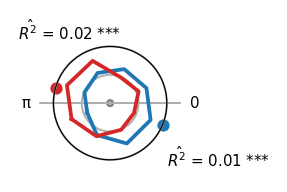

In [8]:
fig, ax = plt.subplots(subplot_kw={'polar':True}, num='fig2_spikephase_hist')

# Plot tonic spike and burst phase histograms and preferred phase
max_radius = 0.2
plot_circhist(tonic_phases, ax=ax, bins=PHASEBINS, color=COLORS['tonicspk'])
ax.scatter(tonicspk_phase, max_radius, color=COLORS['tonicspk'], s=15)
plot_circhist(burst_phases, ax=ax, bins=PHASEBINS, color=COLORS['burst'])
ax.scatter(burst_phase, max_radius, color=COLORS['burst'], s=15)
ax.set_ylim(top=max_radius)

# Center dot
ax.scatter(0, 0, fc='none', ec='gray', s=5)
# Bold outline at max. radius
ax.plot(np.linspace(-np.pi, np.pi, 1000), np.full(1000, max_radius), color='black', lw=0.5)

# Format phase axis
ax.set_frame_on(False)
ax.set_xticks([0, np.pi])
ax.set_xticklabels(['0', '\u03C0'])
ax.tick_params(pad=-5)

# Format radial axis (spike density)
ax.set_yticks(np.arange(0, 0.3, 0.1))
ax.set_yticklabels([])
ax.set_ylim((0, 0.2 + 0.05))
ax.set_rlabel_position(90)

# Print coupling strengths and significance level
ax.text(-0.15, 0.95, '$\hat{R^2}$ = %1.2f %s' % (burst_strength, p2stars(burst_p)), fontsize=LABELFONTSIZE, transform=ax.transAxes)
ax.text(0.9, 0.05, '$\hat{R^2}$ = %1.2f %s' % (tonicspk_strength, p2stars(tonicspk_p)), fontsize=LABELFONTSIZE, transform=ax.transAxes)

set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'phase_hist' + FIGSAVEFORMAT)

### Figure 2C
Phase coupling across the entire population of neurons.

In [9]:
# Load phase coupling data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df = load_data('phasetuning', conditions)

# Assign significance based on p-value from shuffled permutation test
df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
df['burst_sig'] = df['burst_p'] <= 0.05

# Print a summary of coupling across the population of neurons
coupling_summary(df)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl
Neurons with significant coupling: 0.981 (153/156)
Tonicspk prop. significant: 0.981 (153/156)
Tonicspk num. CPDs per neuron: 4.36, 1.52
Burst prop. significant: 0.849 (107/126)
Burst num. CPDs per neuron: 2.48, 1.71


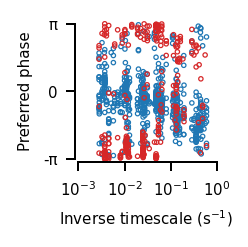

In [10]:
# Make phase-frequency scatter plot
fig, ax = plt.subplots()
phase_coupling_scatter(df, ax=ax)

set_plotsize(w=2, h=2)
clip_axes_to_ticks(ax=ax)
fig.savefig(FIGUREPATH + 'phase_tuning_scatter_spontaneous' + FIGSAVEFORMAT)

### Figure 2D
Tonic - burst phase differences.

In [11]:
# Only consider neurons with significant coupling to both spike types
df_sig = df.query('(tonicspk_sig == True) & (burst_sig == True)').sort_values('freq')  # sort by timescale
df_sig['phase_diff'] = df_sig.apply(lambda x: angle_subtract(x['tonicspk_phase'], x['burst_phase']), axis='columns')

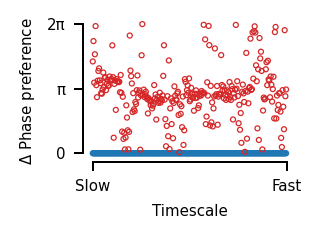

In [12]:
# Plot burst preferred phase relative to tonicspk preferred phase for each neuron
fig, ax = plt.subplots()
pos = np.arange(len(df_sig))
ax.scatter(pos, np.zeros_like(pos), s=4, fc='none', ec=COLORS['tonicspk'], lw=0.5)
ax.scatter(pos, df_sig['phase_diff'], s=4, fc='none', ec=COLORS['burst'], lw=0.5)

# Format axes
ax.set_xticks([0, len(df_sig)])
ax.set_xticklabels(['Slow', 'Fast'])
ax.set_xlabel('Timescale')
ax.set_yticks([0, np.pi, 2 * np.pi])
ax.set_yticklabels(['0', '\u03C0', '2\u03C0'])
ax.set_ylim(bottom=-0.4, top=2 * np.pi + 0.2)
ax.set_ylabel('$\Delta$ Phase preference')

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'phase_diff_scatter' + FIGSAVEFORMAT)

Mean phase diff: 2.82
V 1.39e+02, p 0.00e+00
N = 278 neuron-CPD pairs


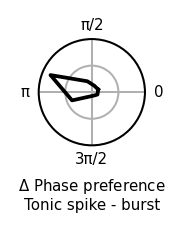

In [13]:
# Get mean burst-tonic phase difference
mean = circmean_angle(df_sig['phase_diff'])
print(f'Mean phase diff: {mean:.2f}')
# V-test for non-uniformity and mean of pi
p, v = vtest(df_sig['phase_diff'], np.pi)  
print(f'V {v:.2e}, p {p:.2e}')
print(f"N = {len(df_sig['phase_diff'])} neuron-CPD pairs")

# Plot circular histogram of burst-tonic phase difference distirbution
ax, _ = plot_circhist(df_sig['phase_diff'], bins=np.linspace(0, 2 * np.pi, 9), color='black')

# Format axes
ax.set_xlabel('$\Delta$ Phase preference' + '\nTonic spike - burst')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])

set_plotsize(w=1.5, h=1.5)
ax.get_figure().savefig(FIGUREPATH + 'phase_diff_circhist' + FIGSAVEFORMAT)

### Figure 2E
Tonic and burst tuning strengths, binned by CPD timescale.

burst: 
Krusakl-Wallis: k=3.340e+01, p=3.138e-06
N=312 CPD-neuron pairs
tonicspk: 
Krusakl-Wallis: k=6.557e+01, p=8.537e-13
N=680 CPD-neuron pairs
Burst vs tonic: w=3.126e+03, p=8.022e-34
N = 278 CPD-neuron pairs


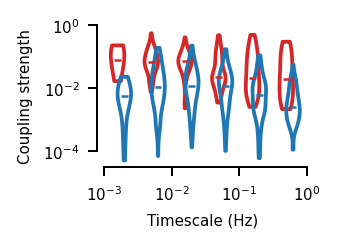

In [14]:
fig, ax = plt.subplots()

positions = np.log10(FREQUENCYBINS[:-1]) + 0.25  # x-positions of violin plots
xoffset = 0.05  # offset to stagger burst and tonic spike distributions
for spk_type in ['burst', 'tonicspk']:
    # Get all neuron IMF pairs with significant coupling
    df_sig = df.query(f'{spk_type}_sig == True').copy()
    df_sig = df_sig.query(f'{spk_type}_strength >= 0')  # needed to ensure log transform, very rare but possible that couping strength is < 0

    # Sort coupling strengths according to CPD timescale
    strengths = sort_data(df_sig['%s_strength' % spk_type], df_sig['freq'], bins=FREQUENCYBINS)

    # Violin plot for each timescale bin, log-transformed couplign strengths
    violins = ax.violinplot([np.log10(s) for s in strengths], positions - xoffset, widths=0.2, showmedians=True, showextrema=False)
    # Some formatting to make the plots look nice
    for violin in violins['bodies']:
        violin.set_facecolor('none')
        violin.set_edgecolor(COLORS[spk_type])
        violin.set_linewidth(1.5)
        violin.set_alpha(1)
    violins['cmedians'].set_color(COLORS[spk_type])
    violins['cmedians'].set_linewidth(1)
    xoffset *= -1  # update offset for next spike type

    # Perform Kruskal-Wallis test for differences in coupling strength across timescale bins
    print(f"{spk_type}: ")
    k, p = kruskal(*[s for s in strengths if len(s) > 2])  # only include timescale bins with more than two coupled neurons 
    print(f"Krusakl-Wallis: k={k:.3e}, p={p:.3e}")
    print(f"N={sum([len(s) for s in strengths])} CPD-neuron pairs")

# Format x-axis
ax.set_xticks(FREQUENCYTICKS)
ax.set_xticklabels(FREQUENCYTICKLABELS)
ax.set_xlim(left=-3.11)
ax.set_xlabel('Timescale (Hz)')

# Format y-axis
yticks = [-4, -2, 0]
ax.set_yticks(yticks)
ax.set_yticklabels(['$10^{%d}$' % tick for tick in yticks])
ax.set_ylabel('Coupling strength')

# Wilcoxon test comparing burst coupling and tonic coupling strengths overall
df_sig = df.query('(tonicspk_sig == True) & (burst_sig == True)')  # only for neurons with significant coupling in both spike types
w, p = wilcoxon(df_sig['burst_strength'], df_sig['tonicspk_strength'])
print(f"Burst vs tonic: w={w:.3e}, p={p:.3e}")
print(f"N = {len(df_sig)} CPD-neuron pairs")

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2, ax=ax)
fig.savefig(FIGUREPATH + 'tuning_strength' + FIGSAVEFORMAT)

### Fig 3F
Coupling strength decay from strongest to weakest timescale.

In [15]:
# Load spike data from gray screen and sparsenoise experiments
# 'desync': coupling measured only after removal of periods in which
# the IMF couples to other IMFs in the recording ('desync')
conditions = ['spontaneous', 'sparsenoise']
df_desync = load_data('phasetuning', conditions, subsample='desync')

# Assign significance based on p-value from shuffled permutation test
df_desync['tonicspk_sig'] = df_desync['tonicspk_p'] <= 0.05
df_desync['burst_sig'] = df_desync['burst_p'] <= 0.05

coupling_summary(df_desync)

Loading:  phasetuning_spontaneous_desync.pkl
Loading:  phasetuning_sparsenoise_desync.pkl
Neurons with significant coupling: 0.986 (146/148)
Tonicspk prop. significant: 0.980 (145/148)
Tonicspk num. CPDs per neuron: 3.80, 1.57
Burst prop. significant: 0.742 (89/120)
Burst num. CPDs per neuron: 2.08, 1.71


Tonicspk 1->2: 62%
Burst 1->2: 63%


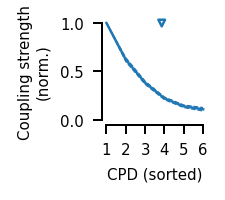

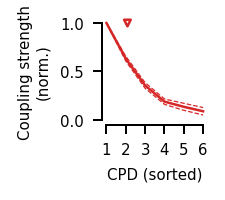

In [27]:
for spk_type in ['tonicspk', 'burst']:
    # Get unit-IMF pairs with significant coupling, group by neuron
    units = df_desync.query('%s_sig == True' % spk_type).groupby(['m', 's', 'e', 'u'])
    # Get sorted, normalized coupling strengths for each neuron
    strengths = np.full((len(units), 6), np.nan)
    for i, (idx, unit) in enumerate(units):
        s = np.sort(unit['%s_strength' % spk_type]) / np.nanmax(unit['%s_strength' % spk_type])
        strengths[i, :len(s)] = np.flip(s) 
    # Mean strength decay across neurons
    decay = np.nanmean(strengths, axis=0)
    print(f"{spk_type.capitalize()} 1->2: {decay[1] * 100:.0f}%")  # second strongest as percentage of first
    err = sem(strengths, nan_policy='omit', axis=0)  # standard error of mean

    # Plot mean strengths and SE
    fig, ax = plt.subplots()
    ax.plot(decay, color=COLORS['%s' % spk_type], lw=1)
    ax.plot(decay + err, color=COLORS['%s' % spk_type], ls='--', lw=0.5)
    ax.plot(decay - err, color=COLORS['%s' % spk_type], ls='--', lw=0.5)

    # Plot mean number of CPDs with significant tuning per neuron
    units = df_desync.dropna(subset='burst_p').groupby(['m', 's', 'e', 'u'])
    n_imfs = units.apply(lambda x: x[f'{spk_type}_sig'].sum()).mean()
    ax.scatter(n_imfs - 1, 1, marker='v', s=7, fc='none', ec=COLORS[spk_type])

    # Format axes
    ax.set_xticks(np.arange(len(decay)))
    ax.set_xticklabels(np.arange(len(decay)) + 1)
    ax.set_xlabel('CPD (sorted)')
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim(bottom=-0.05, top=1.05)
    ax.set_ylabel('Coupling strength\n(norm.)')
    
    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=1.5, h=1.5, ax=ax)
    fig.savefig(FIGUREPATH + f'coupling_strength_decay_{spk_type}.svg')

### Figure 2G
Distribution of preferred timescales for each recording session.

Tonicspk
             df    sum_sq   mean_sq         F   PR(>F)
C(mse)     14.0  0.452917  0.032351  3.159218  0.00025
Residual  141.0  1.443876  0.010240       NaN      NaN
Burst
             df    sum_sq   mean_sq        F   PR(>F)
C(mse)     14.0  0.372257  0.026590  2.57268  0.00252
Residual  141.0  1.457300  0.010335      NaN      NaN


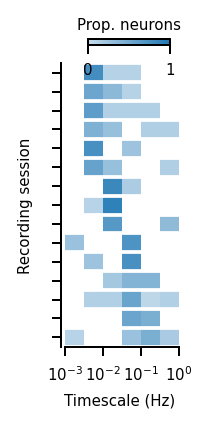

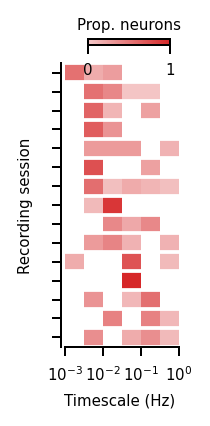

In [28]:
for spk_type in ['tonicspk', 'burst']:
    # Get IMF with strongest coupling for each neuron
    units = df.groupby(['m', 's', 'e', 'u'])
    pref_timescale = units.apply(lambda x: x['freq'].iloc[np.argmax(x[f'{spk_type}_strength'])])
    # Get the distribution of strongest coupling timescales for each recording session
    sessions = pref_timescale.groupby(['m', 's', 'e'])
    session_dist = sessions.apply(lambda x: np.histogram(x, bins=FREQUENCYBINS, weights=np.ones_like(x) / len(x))[0])
    modes = session_dist.apply(np.argmax)  # mode of each distribution
    mat = np.row_stack(session_dist.loc[modes.sort_values().index])  # stack distributions into a matrix, sorted by mode
    
    # Convert strongest IMF Series into a DataFrame
    df_anova = pd.DataFrame(pref_timescale.values, columns=['timescale'])
    # Combine MSE dict into a single string identifier for the session
    df_anova['mse'] = [('_').join([str(i) for i in idx[:-1]]) for idx in pref_timescale.index]
    # Perform ANOVA, does preferred timescale vary significantly across recordings?
    anova_model = ols('timescale ~ C(mse)', data=df_anova).fit()  # use formula to specify model
    print(spk_type.capitalize()) 
    print(sm.stats.anova_lm(anova_model))

    # Make a piece-wise linear colormap to be able to see small values
    # but still have linear color scaling
    nodes = [0.0, mat.min(), 1.0]
    rgba = np.array(to_rgba(COLORS[spk_type]))
    rgba2 = rgba.copy()
    rgba2[-1] = 0.25  # minimum entry in mat has alpha=0.25
    cmap = LinearSegmentedColormap.from_list(spk_type, list(zip(nodes, ['white', rgba2, rgba])))

    # Plot distributions (each row is one recording session)
    fig, ax = plt.subplots()
    im = ax.imshow(mat, cmap=cmap, vmin=0, vmax=1)
    # Add white lines between rows
    for i in range(len(mat) + 1):
        ax.axhline(i - 0.5, color='white')

    # Colorbar
    bbox = ax.get_position()
    cax = fig.add_axes([bbox.x0, bbox.y1 + 0.05, 0.3, 0.015])
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[0, 1], label='Prop. neurons')
    cax.xaxis.set_label_position('top')

    # Format axes
    ax.set_xticks(np.arange(len(FREQUENCYBINS))[::2] - 0.5)
    ax.set_xticklabels(FREQUENCYTICKLABELS)
    ax.set_xlabel("Timescale (Hz)")
    ax.set_xlim(left=-0.75)
    ax.set_yticks(np.arange(len(mat)))
    ax.set_yticklabels([])
    ax.set_ylabel('Recording session')
    
    clip_axes_to_ticks(ax=ax, ext={'left':(-0.5, 0.5)})
    set_plotsize(w=3, h=4, ax=ax)
    fig.savefig(FIGUREPATH + f'timescale_prefs_{spk_type}' + FIGSAVEFORMAT)

### Figure 3A
Pupil size matching: try to minimize differences in pupil size distribution across phase bins of each CPD via sub-sampling.

In [29]:
# Load Hilbert-Huang transform pupil data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df_hht = load_data('hht', conditions)

# Get mean pupil size difference across phase bins for each IMF
sizematching = []  # data for each IMF will be collected in this list
for idx, row in df_hht.iterrows():  # loop over recordings
    # Need to unpack data for each IMF from arrays stored for each recording
    # matched/ unmatched: pair-wise comparison of mean pupil size across IMF phase bins
    for (unmatched, matched, freq) in zip(row['unmatched_meansize'], row['matched_meansize'], row['frequency']):
        # Store data for each IMF in a dict
        data = {'m':row['m'], 's':row['s'], 'e':row['e']}  # recording session ID
        data['freq'] = freq  # charactersitic frequency of IMF
        # Get the pupil size diff: each combination of phase bins of IMF has a 
        # mean pupil size difference, we collect the maximum difference
        data['unmatched_diff'] = np.nanmax(np.abs(unmatched))
        data['matched_diff'] = np.nanmax(np.abs(matched))
        # Append IMF data dict to list
        sizematching.append(data)
# Convert list of dicts to dataframe, sort by IMF frequency
df_sizematching = pd.DataFrame(sizematching).sort_values('freq')

Loading:  hht_spontaneous.pkl
Loading:  hht_sparsenoise.pkl


/tmp/ipykernel_53393/1370940349.py:17: RuntimeWarning: All-NaN slice encountered
  data['matched_diff'] = np.nanmax(np.abs(matched))


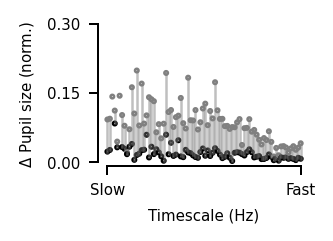

In [30]:
# Plot pupil size difference across phase bins before and after matching procedure
fig, ax = plt.subplots()

# Each IMF get a line, IMFs arranged by frequency
positions = np.arange(len(df_sizematching))
for pos, (idx, row) in zip(positions, df_sizematching.iterrows()):
    # Plot line and two dots representing the pupil size difference before and after the matching procedure
    ax.plot([pos, pos], [row['unmatched_diff'], row['matched_diff']], lw=1, color='gray', alpha=0.5)
    ax.scatter(pos, row['unmatched_diff'], s=2, fc='none', ec='gray')  # before matching
    ax.scatter(pos, row['matched_diff'], s=2, fc='none', ec='black')  # after matching

# Format axes
ax.set_xticks([0, positions.max()])
ax.set_xticklabels(['Slow', 'Fast'])
ax.set_xlabel('Timescale (Hz)')
ax.set_yticks([0, 0.15, 0.3])
ax.set_ylabel('$\Delta$ Pupil size (norm.)')

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'pupil_size_diffs' + FIGSAVEFORMAT)

### Figure 3B
Burst-tonic spike phase difference before and after pupil size matching.

In [33]:
conditions = ['spontaneous', 'sparsenoise']
df = load_data('phasetuning', conditions)
df_sizematched = load_data('phasetuning', conditions, subsample='sizematched')

df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
df['burst_sig'] = df['burst_p'] <= 0.05
df_sizematched['tonicspk_sig'] = df_matched['tonicspk_p'] <= 0.05
df_sizematched['burst_sig'] = df_matched['burst_p'] <= 0.05

coupling_summary(df_sizematched)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl
Loading:  phasetuning_spontaneous_sizematched.pkl
Loading:  phasetuning_sparsenoise_sizematched.pkl
Neurons with significant coupling: 0.939 (139/148)
Tonicspk prop. significant: 0.939 (139/148)
Tonicspk num. CPDs per neuron: 3.30, 1.70
Burst prop. significant: 0.636 (77/121)
Burst num. CPDs per neuron: 0.95, 0.95


Sizematched mean: -2.9429396141792523
V 2.037e+01, p 6.402e-04
N = 80


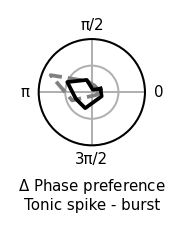

In [34]:
bins = np.linspace(0, 2 * np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})

# Plot the circular distribution for burst-tonic spike phase differences
df_sig = df.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_all = (df_sig['tonicspk_phase'] - df_sig['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_all, bins=bins, ax=ax, color='gray', ls='--')

# Plot the circular distribution for burst-tonic spike phase differences in 'sizematched' periods
df_sig = df_sizematched.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_sizematched = (df_sig['tonicspk_phase'] - df_sig['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_sizematched, bins=bins, ax=ax, color='black')

# V-test for non-uniformity and mean of pi
p, v = vtest(phase_diff_sizematched, np.pi)
print(f'Sizematched mean: {circmean_angle(phase_diff_sizematched)}')
print(f"V {v:.3e}, p {p:.3e}")
print(f"N = {len(phase_diff_sizematched)}")

# Format axes
ax.set_xlabel(r'$\Delta$ Phase preference' + '\nTonic spike - burst')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_diff_circhist_sizematched' + FIGSAVEFORMAT)

### Figure SC
Median coupling strength across timescale bins after pupil size matching procedure, compared to control condition prior to the sub-sampling. 

Tonicspk median: 0.0081, N: 682
Tonicspk size-matched median: 0.0046, N: 489
MannwhitneyuResult(statistic=195583.0, pvalue=4.3682907893601896e-07)
Burst median: 0.0528, N: 320
Burst size-matched median: 0.0250, N: 115
MannwhitneyuResult(statistic=22192.0, pvalue=0.001041948334988583)
[False, True, True, True, False, False]
[False, False, True, False, False, False]


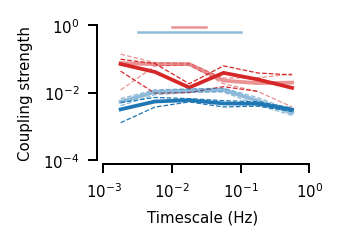

In [36]:
fig, ax = plt.subplots()
ax = coupling_strength_line_plot(df_matched, agg=np.median, err=se_median, ax=ax)
ax = coupling_strength_line_plot(df, agg=np.median, err=se_median, ax=ax, alpha=0.5)

for spk_type in ['tonicspk', 'burst']:
    strengths = df.query(f'{spk_type}_sig == True')[f'{spk_type}_strength']
    strengths_matched = df_matched.query(f'{spk_type}_sig == True')[f'{spk_type}_strength']
    print(f'{spk_type.capitalize()} median: {strengths.median():.4f}, N: {len(strengths)}')
    print(f'{spk_type.capitalize()} size-matched median: {strengths_matched.median():.4f}, N: {len(strengths_matched)}')
    print(mannwhitneyu(strengths, strengths_matched))

# Code snip for post-hoc tests
for spk_type in ['tonicspk', 'burst']:
    df_sig = df_sizematched.query(f'{spk_type}_sig == True')
    strengths_matched = sort_data(df_sig[f'{spk_type}_strength'], df_sig['freq'], bins=FREQUENCYBINS)
    df_sig = df.query(f'{spk_type}_sig == True')
    strengths = sort_data(df_sig[f'{spk_type}_strength'], df_sig['freq'], bins=FREQUENCYBINS)
    ps = np.full(len(FREQUENCYBINS) - 1, np.nan)
    for f_bin, (s_matched, s) in enumerate(zip(strengths_matched, strengths)):
        ps[f_bin] = mannwhitneyu(s_matched, s).pvalue
    print([p <= 0.05 for p in ps])
# Need to make sure these lines match the printed significance tests for each frequency bin
ax.plot([FREQUENCYXPOS[2] - 0.25, FREQUENCYXPOS[2] + 0.25], [-0.05, -0.05], color=COLORS['burst'], lw=1, alpha=0.5)
ax.plot([FREQUENCYXPOS[1] - 0.25, FREQUENCYXPOS[3] + 0.25], [-0.2, -0.2], color=COLORS['tonicspk'], lw=1, alpha=0.5)

yticks = [-4, -2, 0]
ax.set_yticks(yticks)
ax.set_yticklabels(['10$^{%d}$' % tick for tick in yticks])
ax.set_ylim(bottom=-4.1)

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'coupling_strength_sizematched' + FIGSAVEFORMAT)

### Figure 3D
Pie charts of the proportion of neurons that 1) retai their coupling timescale preference, 2) switch their coupling timescale preference, 3) lose their coupling after sub-sampling for pupil size matching. Timescale preference refers to the CPD with the strongest coupling for the given neuron. Also check to see which neurons increase their coupling strength overall after sub-sampling.

In [37]:
# Load phase coupling data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df_all = load_data('phasetuning', conditions)
# Coupling data measured after sub-sampling for pupil size matching
df_sizematched = load_data('phasetuning', conditions, subsample='sizematched')

# Assign significance based on p-value from shuffled permutation test
df_all['tonicspk_sig'] = df_all['tonicspk_p'] <= 0.05
df_all['burst_sig'] = df_all['burst_p'] <= 0.05
df_sizematched['tonicspk_sig'] = df_sizematched['tonicspk_p'] <= 0.05
df_sizematched['burst_sig'] = df_sizematched['burst_p'] <= 0.05

# Combine control and sub-sampled data
df_all = df_all.set_index(['m', 's', 'e', 'u', 'imf']).sort_index()
df_sizematched = df_sizematched.set_index(['m', 's', 'e', 'u', 'imf']).sort_index()
suffixes = ['_all', '_sizematched']
df = pd.merge(df_all, df_sizematched, left_index=True, right_index=True, suffixes=suffixes)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl
Loading:  phasetuning_spontaneous_sizematched.pkl
Loading:  phasetuning_sparsenoise_sizematched.pkl


In [38]:
def compare_coupling_strength_preferences(df, conds, spk_type):
    df_sig = df.query(f'({spk_type}_sig_all == True)')
    
    def _pref_timescale(unit):
        pref_cond0 = np.argmax(unit[f'{spk_type}_strength_{conds[0]}'])
        pref_cond1 = np.argmax(unit[f'{spk_type}_strength_{conds[1]}'])
        return pref_cond0 != pref_cond1
    def _max_strength(unit):
        strength_cond0 = unit[f'{spk_type}_strength_{conds[0]}'].max()
        strength_cond1 = unit[f'{spk_type}_strength_{conds[1]}'].max()
        return strength_cond1 - strength_cond0

    units = df_sig.groupby(['m', 's', 'e', 'u'])
    sig = (units.apply(lambda x: x[f'{spk_type}_sig_{conds[1]}'].sum() > 0))
    shift = units.apply(_pref_timescale)
    strength = units.apply(_max_strength)
    no_coupling = (~sig).sum()
    imf_same_down = (sig & ~shift & (strength < 0)).sum()
    imf_same_up = (sig & ~shift & (strength >= 0)).sum()
    imf_shift_down = (sig & shift & (strength < 0)).sum()
    imf_shift_up = (sig & shift & (strength >= 0)).sum()

    total = np.sum([no_coupling, imf_shift_down, imf_shift_up, imf_same_up, imf_same_down])
    print("No coupling: %.1f" % (no_coupling / total * 100))
    print("Timescale same: %.1f" % (np.sum([imf_same_up, imf_same_down]) / total * 100))
    print("Timescale shift: %.1f" % (np.sum([imf_shift_up, imf_shift_down]) / total * 100))
    print("Increased coupling: %.1f" % (np.sum([imf_shift_up, imf_same_up]) / total * 100))
    
    fig, ax = plt.subplots()
    slices, text = ax.pie([no_coupling, imf_shift_down, imf_shift_up, imf_same_up, imf_same_down],
                    explode=[0., 0., 0.1, 0.1, 0.],
                    colors=['gray', COLORS[spk_type], COLORS[spk_type], COLORS[spk_type], COLORS[spk_type]])
    slices[1].set_alpha(0.5)
    slices[2].set_alpha(0.5)
    plt.legend(slices[::2], ['No coupling', 'Timescale shift', 'Timescale retained'], loc=(1, 0.75), frameon=False)
    ax.xaxis.set_visible(False)
    return ax

Tonicspk
No coupling: 5.5
Timescale same: 38.6
Timescale shift: 55.9
Increased coupling: 25.5
Burst
No coupling: 39.6
Timescale same: 30.2
Timescale shift: 30.2
Increased coupling: 15.1


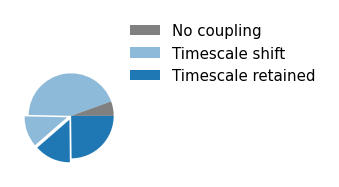

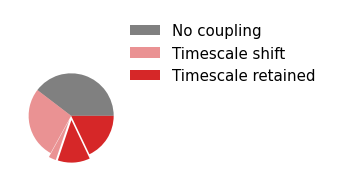

In [39]:
for spk_type in ['tonicspk', 'burst']:
    print(spk_type.capitalize())
    ax = compare_coupling_strength_preferences(df, ['all', 'sizematched'], spk_type)
    
    set_plotsize(w=2, h=1.5)
    fig = ax.get_figure()
    fig.savefig(FIGUREPATH + f'sizematching_{spk_type}_pie' + FIGSAVEFORMAT)

### Figure 4A
Phase tuning analyses after eliminating spikes occurring during locomotion, and excluding the transition period between locomotion and quiescence.

In [40]:
conditions = ['spontaneous', 'sparsenoise']

df = load_data('phasetuning', conditions).set_index(['m', 's', 'e', 'u'])
df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
df['burst_sig'] = df['burst_p'] <= 0.05
df['freq_bin'] = np.digitize(df['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1)
print("\nAll")
coupling_summary(df)

df_sit = load_data('phasetuning', conditions, subsample='sit').set_index(['m', 's', 'e', 'u'])
df_sit['tonicspk_sig'] = df_sit['tonicspk_p'] <= 0.05
df_sit['burst_sig'] = df_sit['burst_p'] <= 0.05
df_sit['freq_bin'] = np.digitize(df_sit['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1)
print("\nQuiescence")
coupling_summary(df_sit)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl

All
Neurons with significant coupling: 0.981 (153/156)
Tonicspk prop. significant: 0.981 (153/156)
Tonicspk num. CPDs per neuron: 4.37, 1.53
Burst prop. significant: 0.873 (110/126)
Burst num. CPDs per neuron: 2.54, 1.70
Loading:  phasetuning_spontaneous_sit.pkl
Loading:  phasetuning_sparsenoise_sit.pkl

Quiescence
Neurons with significant coupling: 0.973 (143/147)
Tonicspk prop. significant: 0.973 (143/147)
Tonicspk num. CPDs per neuron: 4.02, 1.57
Burst prop. significant: 0.771 (84/109)
Burst num. CPDs per neuron: 2.35, 1.80


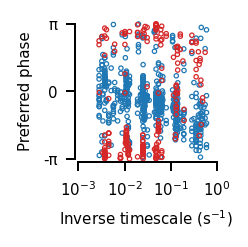

In [41]:
fig, ax = plt.subplots()

ax = phase_coupling_scatter(df_sit, ax=ax)
set_plotsize(w=2, h=2)
clip_axes_to_ticks(ax=ax)

fig.savefig(FIGUREPATH + 'phase_coupling_scatter_sit.svg')

Sit mean: 2.8498524496245317
V 1.111e+02, p 0.000e+00


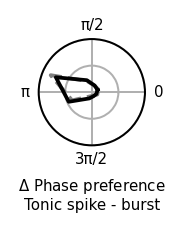

In [42]:
bins = np.linspace(0, 2 * np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})

df_sig = df.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff = (df_sig['tonicspk_phase'] - df_sig['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff, bins=bins, ax=ax, color='gray', ls='--')

df_sig_sit = df_sit.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_sit = (df_sig_sit['tonicspk_phase'] - df_sig_sit['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_sit, bins=bins, ax=ax, color='black')

ax.set_xlabel(r'$\Delta$ Phase preference' + '\nTonic spike - burst')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])
# ax.set_ylim(top=0.5)

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_diff_circhist_sit.svg')

N = len(phase_diff_sit)
print(f'Sit mean: {circmean_angle(phase_diff_sit)}')
p, v = vtest(phase_diff_sit, np.pi)
print(f'V {v:.3e}, p {p:.3e}')

Tonicspk median: 0.0081, N: 682
Tonicspk sit median: 0.0100, N: 591
MannwhitneyuResult(statistic=186930.0, pvalue=0.025617164206934048)
Burst median: 0.0528, N: 320
Burst sit median: 0.0564, N: 256
MannwhitneyuResult(statistic=38821.0, pvalue=0.2812572605274605)


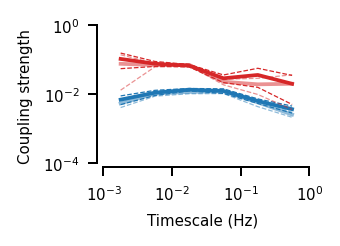

In [43]:
fig, ax = plt.subplots()
ax = coupling_strength_line_plot(df_sit, agg=np.median, err=se_median, ax=ax)
ax = coupling_strength_line_plot(df, agg=np.median, err=se_median, ax=ax, alpha=0.5)

yticks = [-4, -2, 0]
ax.set_yticks(yticks)
ax.set_yticklabels(['10$^{%d}$' % tick for tick in yticks])
ax.set_ylim(bottom=-4.1)

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'coupling_strength_sit.svg')

for event in ['tonicspk', 'burst']:
    strengths = df.query(f'{event}_sig == True')[f'{event}_strength']
    strengths_sit = df_sit.query(f'{event}_sig == True')[f'{event}_strength']
    print(f'{event.capitalize()} median: {strengths.median():.4f}, N: {len(strengths)}')
    print(f'{event.capitalize()} sit median: {strengths_sit.median():.4f}, N: {len(strengths_sit)}')
    print(mannwhitneyu(strengths, strengths_sit))

### Figure 4B
Phase tuning analyses after eliminating spikes occurring during quiescence, and excluding the transition period between locomotion and quiescence.

In [44]:
conditions = ['spontaneous', 'sparsenoise']

df_run = load_data('phasetuning', conditions, subsample='run')
df_run['tonicspk_sig'] = df_run['tonicspk_p'] <= 0.05
df_run['burst_sig'] = df_run['burst_p'] <= 0.05
df_run['freq_bin'] = np.digitize(df_run['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1)
coupling_summary(df_run)

Loading:  phasetuning_spontaneous_run.pkl
Loading:  phasetuning_sparsenoise_run.pkl
Neurons with significant coupling: 0.902 (129/143)
Tonicspk prop. significant: 0.853 (122/143)
Tonicspk num. CPDs per neuron: 2.51, 1.65
Burst prop. significant: 0.779 (60/77)
Burst num. CPDs per neuron: 1.73, 1.37


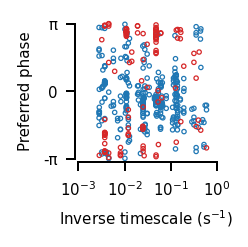

In [45]:
fig, ax = plt.subplots()

ax = phase_coupling_scatter(df_run, ax=ax)
set_plotsize(w=2, h=2)
clip_axes_to_ticks(ax=ax)

fig.savefig(FIGUREPATH + 'phase_coupling_scatter_run.svg')

V 5.665e+01, p 0.000e+00
Run mean: 3.1312927449591803


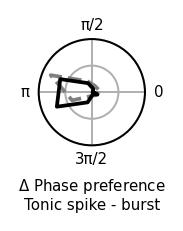

In [46]:
bins = np.linspace(0, 2 * np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})

df_sig = df.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff = (df_sig['tonicspk_phase'] - df_sig['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff, bins=bins, ax=ax, color='gray', ls='--')

df_sig_run = df_run.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_run = (df_sig_run['tonicspk_phase'] - df_sig_run['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_run, bins=bins, ax=ax, color='black')

ax.set_xlabel(r'$\Delta$ Phase preference' + '\nTonic spike - burst')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])
# ax.set_ylim(top=0.5)

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_diff_circhist_run.svg')

N = len(phase_diff_run)
p, v = vtest(phase_diff_run, np.pi)
print(f'V {v:.3e}, p {p:.3e}')
print(f'Run mean: {circmean_angle(phase_diff_run)}')

Tonicspk median: 0.0081, N: 682
Tonicspk run median: 0.0254, N: 359
MannwhitneyuResult(statistic=71533.0, pvalue=2.5620688026174607e-28)
Burst median: 0.0528, N: 320
Burst run median: 0.0927, N: 133
MannwhitneyuResult(statistic=13432.0, pvalue=6.236365385831146e-10)


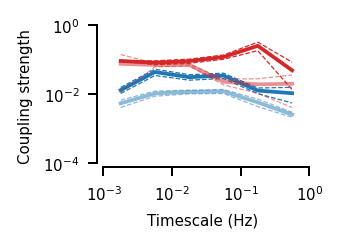

In [47]:
fig, ax = plt.subplots()
ax = coupling_strength_line_plot(df_run, agg=np.median, err=se_median, ax=ax)
ax = coupling_strength_line_plot(df, agg=np.median, err=se_median, ax=ax, alpha=0.5)

yticks = [-4, -2, 0]
ax.set_yticks(yticks)
ax.set_yticklabels(['10$^{%d}$' % tick for tick in yticks])
ax.set_ylim(bottom=-4.1)

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'coupling_strength_run.svg')

for event in ['tonicspk', 'burst']:
    strengths = df.query(f'{event}_sig == True')[f'{event}_strength']
    strengths_run = df_run.query(f'{event}_sig == True')[f'{event}_strength']
    print(f'{event.capitalize()} median: {strengths.median():.4f}, N: {len(strengths)}')
    print(f'{event.capitalize()} run median: {strengths_run.median():.4f}, N: {len(strengths_run)}')
    print(mannwhitneyu(strengths, strengths_run))

### Figure 4C
Phase tuning analyses after eliminating spikes occurring during saccades, and peri-saccadic period.

Loading:  pupil_sparsenoise.pkl
Loading:  pupil_spontaneous.pkl


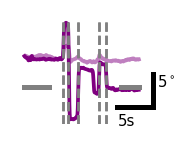

In [48]:
df_pupil = load_data('pupil', ['sparsenoise', 'spontaneous']).set_index(['m', 's', 'e'])

# TODO: move this to parameters
key = {'m': 'PVCre_2019_0002', 's': 7, 'e':9}
t0, t1 = 177, 193

fig, ax = plt.subplots()

tpts = df_pupil['pupil_tpts'].loc[key2idx(key)]
i0, i1 = tpts.searchsorted([t0, t1])

az = df_pupil['pupil_azimuth'].loc[key2idx(key)]
ax.plot(tpts[i0:i1], az[i0:i1] - np.nanmedian(az), color=COLORS['azimuth'])
el = df_pupil['pupil_elevation'].loc[key2idx(key)]
ax.plot(tpts[i0:i1], el[i0:i1] - np.nanmedian(el), color=COLORS['elevation'])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
#ax.invert_yaxis()

saccades = df_pupil['saccade_times'].loc[key2idx(key)]
saccades = saccades[(saccades >= t0) & (saccades <= t1)]
for saccade in saccades:
    ax.axvline(saccade, lw=1, ls='--', color='gray')
    ax.axvline(saccade, lw=1, ls='--', color='gray')
    
saccade_tranges = np.column_stack([saccades - 2, saccades + 2])
saccade_tranges = merge_ranges(saccade_tranges, dt=np.diff(tpts).mean())
tranges = switch_ranges(saccade_tranges, dt=np.diff(tpts).mean(), minval=t0, maxval=t1)
for rt0, rt1 in tranges:
    ax.plot([rt0, rt1], [-5, -5], lw=2, color='gray')

ax.plot([t1 - 3, t1 + 2], [-8, -8], lw=2, color='black')
ax.text(t1 - 3, -11, '5s', fontsize=LABELFONTSIZE)
ax.plot([t1 + 2, t1 + 2], [-8, -3], lw=2, color='black')
ax.text(t1 + 2.5, -5, '5$^\circ$', fontsize=LABELFONTSIZE)

fig.subplots_adjust(hspace=0)
set_plotsize(w=2, h=1.5)

fig.savefig(FIGUREPATH + 'saccade_example_short.svg')

In [49]:
conditions = ['spontaneous', 'sparsenoise']

df_saccade = load_data('phasetuning', conditions, subsample='nosaccade')
df_saccade['tonicspk_sig'] = df_saccade['tonicspk_p'] <= 0.05
df_saccade['burst_sig'] = df_saccade['burst_p'] <= 0.05
df_saccade['freq_bin'] = np.digitize(df_saccade['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1)
coupling_summary(df_saccade)

Loading:  phasetuning_spontaneous_nosaccade.pkl
Loading:  phasetuning_sparsenoise_nosaccade.pkl
Neurons with significant coupling: 0.974 (151/155)
Tonicspk prop. significant: 0.974 (151/155)
Tonicspk num. CPDs per neuron: 4.09, 1.60
Burst prop. significant: 0.817 (94/115)
Burst num. CPDs per neuron: 2.47, 1.81


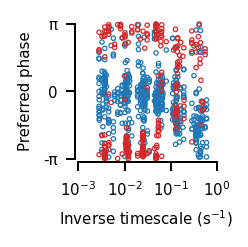

In [50]:
fig, ax = plt.subplots()

ax = phase_coupling_scatter(df_saccade, ax=ax)
set_plotsize(w=2, h=2)
clip_axes_to_ticks(ax=ax)

fig.savefig(FIGUREPATH + 'phase_coupling_scatter_nosaccade.svg')

V 1.315e+02, p 0.000e+00
No saccade mean: 2.908625168749138


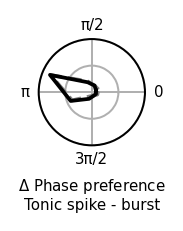

In [51]:
bins = np.linspace(0, 2 * np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})

df_sig = df.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff = (df_sig['tonicspk_phase'] - df_sig['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff, bins=bins, ax=ax, color='gray', ls='--')

df_sig_saccade = df_saccade.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_saccade = (df_sig_saccade['tonicspk_phase'] - df_sig_saccade['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_saccade, bins=bins, ax=ax, color='black')

ax.set_xlabel(r'$\Delta$ Phase preference' + '\nTonic spike - burst')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])
# ax.set_ylim(top=0.5)

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_diff_circhist_nosaccade.svg')

N = len(phase_diff_saccade)
p, v = vtest(phase_diff_saccade, np.pi)
print(f'V {v:.3e}, p {p:.3e}')
print(f'No saccade mean: {circmean_angle(phase_diff_saccade)}')

/home/crombie/code/imftuning_code/util.py:346: RuntimeWarning: invalid value encountered in log10
  ax.plot(FREQUENCYXPOS, np.log10(ys - yerr), color=COLORS[event], lw=0.5, ls='--', **kwargs)


Tonicspk median: 0.0081, N: 682
Tonicspk saccade median: 0.0090, N: 634
MannwhitneyuResult(statistic=205181.0, pvalue=0.109903754705229)
Burst median: 0.0528, N: 320
Burst saccade median: 0.0545, N: 284
MannwhitneyuResult(statistic=45418.0, pvalue=0.9919859878683999)


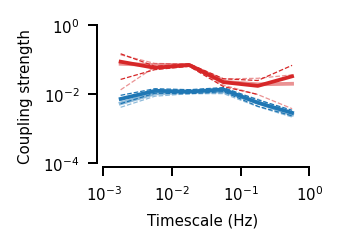

In [52]:
fig, ax = plt.subplots()
ax = coupling_strength_line_plot(df_saccade, agg=np.median, err=se_median, ax=ax)
ax = coupling_strength_line_plot(df, agg=np.median, err=se_median, ax=ax, alpha=0.5)

yticks = [-4, -2, 0]
ax.set_yticks(yticks)
ax.set_yticklabels(['10$^{%d}$' % tick for tick in yticks])
ax.set_ylim(bottom=-4.1)

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'coupling_strength_saccade.svg')

for event in ['tonicspk', 'burst']:
    strengths = df.query(f'{event}_sig == True')[f'{event}_strength']
    strengths_saccade = df_saccade.query(f'{event}_sig == True')[f'{event}_strength']
    print(f'{event.capitalize()} median: {strengths.median():.4f}, N: {len(strengths)}')
    print(f'{event.capitalize()} saccade median: {strengths_saccade.median():.4f}, N: {len(strengths_saccade)}')
    print(mannwhitneyu(strengths, strengths_saccade))

### Figure 5A
Movie responses for an example neuron.

In [53]:
df_spikes = load_data('spikes', ['natmov_opto', 'natmov'])
df_spikes = filter_units(df_spikes, MINRATE)

df_trials = load_data('trials', ['natmov_opto', 'natmov'])
df_trials.rename(columns={'trial_on_time':'trial_on_times', 'trial_off_time':'trial_off_times'}, inplace=True)
df_trials = df_trials.apply(get_trials, stim_id=0, opto=False, axis='columns')

df_spikes = pd.merge(df_spikes, df_trials).set_index(['m', 's', 'e', 'u'])

Loading:  spikes_natmov_opto.pkl
Loading:  spikes_natmov.pkl
Loading:  trials_natmov_opto.pkl
Loading:  trials_natmov.pkl


In [54]:
# Get tonic spike and burst rasters
df_spikes['natmov_tonicspk'] = df_spikes.apply(get_raster, events='trial_on', spike_type='tonicspk', post=5, axis='columns')
df_spikes['natmov_burst'] = df_spikes.apply(get_raster, events='trial_on', spike_type='burst', post=5, axis='columns')

In [55]:
# Get responses to stimuli (incl. pre-trial ISI for baseline)
kwargs = {'pre':-1, 'post':6, 'dt':0.01, 'bw':0.05, 'baseline':[-1, 0]}
tpts = np.arange(kwargs['pre'], kwargs['post'], kwargs['dt'])
# get_psth estimates inst. for each trial
df_spikes['natmov_psth'] = df_spikes.apply(apply_get_psth, events='trial_on', spike_type='spk', **kwargs, axis='columns')

In [56]:
# Get the SNR during the stimulus for each unit
def snr(responses):
    return responses.mean(axis=0).var() / responses.var(axis=0).mean()

i0, i1 = tpts.searchsorted([0, 5])
df_spikes['natmov_rvr'] = df_spikes['natmov_psth'].apply(lambda x: snr(x[:, i0:i1]))

print("RVR median: %.3f" % df_spikes['natmov_rvr'].median())
print("RVR > 1: %.3f (%d/%d)" % ((df_spikes['natmov_rvr'] < 1).sum() / len(df_spikes), (df_spikes['natmov_rvr'] < 1).sum(), len(df_spikes)))
print("RVR > 0.5: %.3f" % ((df_spikes['natmov_rvr'] < 0.5).sum() / len(df_spikes)))

RVR median: 0.160
RVR > 1: 1.000 (64/64)
RVR > 0.5: 0.906


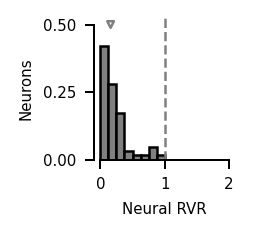

In [57]:
fig, ax = plt.subplots()

bins = np.linspace(0, 2, 17)
weights = np.ones(len(df_spikes)) / len(df_spikes)
ax.hist(df_spikes['natmov_rvr'], bins=bins, weights=weights, lw=1, fc='gray', ec='black')
ax.axvline(1, ls='--', lw=1, color='gray')
ax.scatter(df_spikes['natmov_rvr'].median(), 0.5, marker='v', fc='none', ec='gray', s=7)

ax.set_xticks([0, 1, 2])
ax.set_xlabel('Neural RVR')
ax.set_yticks([0, 0.25, 0.5])
ax.set_ylabel('Neurons')
clip_axes_to_ticks(ax=ax)

set_plotsize(w=2, h=2)

fig.savefig(FIGUREPATH + 'natmov_rvr_spikes.svg')

In [58]:
i0, i1 = tpts.searchsorted([-0.5, 5.5])
df_spikes['natmov_psth'] = df_spikes['natmov_psth'].apply(lambda x: x[:, i0:i1])
df_spikes['natmov_resp'] = df_spikes['natmov_psth'].apply(lambda x: x.mean(axis=0))

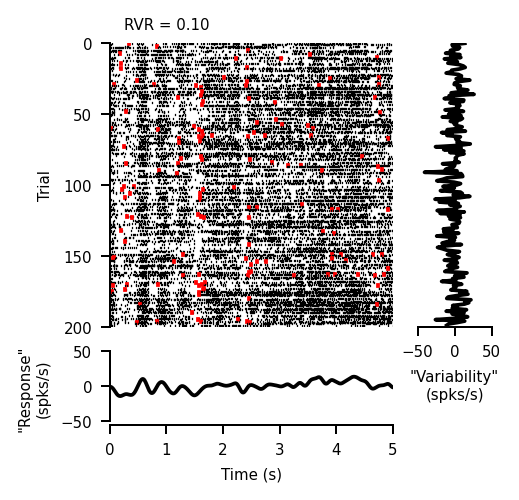

In [59]:
idx = key2idx(FIG5AEXAMPLEKEY)
tonic_raster = df_spikes.loc[idx]['natmov_tonicspk']
burst_raster = df_spikes.loc[idx]['natmov_burst']
rvr = df_spikes.loc[idx]['natmov_rvr']
signal = df_spikes.loc[idx]['natmov_resp']
noise = df_spikes.loc[idx]['natmov_psth'].mean(axis=1)
n_trials = len(tonic_raster)

fig, ax = plt.subplots()
for trial_i, (tonic, burst) in enumerate(zip(tonic_raster, burst_raster)):
    for spike in tonic:
        ax.plot([spike, spike], [trial_i - 0.3, trial_i + 0.3], color='black', lw=0.5)
    for spike in burst:
        ax.plot([spike, spike], [trial_i - 0.3, trial_i + 0.3], color='red', lw=1.5)
ax.set_xlim([0, 5])
ax.set_yticks(np.arange(0, n_trials + 1, 50))
ax.invert_yaxis()
ax.set_ylim([n_trials, 0])
ax.set_ylabel('Trial')
ax.text(0.05, 1.05, f'RVR = {rvr:.2f}', fontsize=LABELFONTSIZE, transform=ax.transAxes)
ax.xaxis.set_visible(False)
clip_axes_to_ticks(ax=ax, spines=['left'])

fig.subplots_adjust(bottom=0.3, right=0.7)
bbox = ax.get_position()

ax_psth = fig.add_axes([bbox.x0, bbox.y0 - 0.2, bbox.width, 0.15])
i0, i1 = tpts.searchsorted([-0.5, 5.5])
ax_psth.plot(tpts[i0:i1], signal - signal.mean(), color='black')
ax_psth.set_xlim([0, 5])
ax_psth.set_xlabel('Time (s)')
ax_psth.set_yticks([-50, 0, 50])
ax_psth.set_ylim(bottom=-55)
ax_psth.set_ylabel('"Response"\n(spks/s)')
clip_axes_to_ticks(ax=ax_psth)

ax_noise = fig.add_axes([bbox.x1 + 0.05, bbox.y0, 0.15, bbox.height])
ax_noise.plot(noise - noise.mean(), np.arange(len(noise)), color='black')
ax_noise.set_xticks([-50, 0, 50])
ax_noise.set_xlabel('"Variability"\n(spks/s)')
ax_noise.yaxis.set_visible(False)
ax_noise.invert_yaxis()
ax_noise.set_ylim([n_trials, 0])

clip_axes_to_ticks(ax=ax_noise, spines=['bottom'])
set_plotsize(w=4, h=4)

fig.savefig(FIGUREPATH + 'natmov_raster.svg')

### Figure 5B
Pupil size movie responses.

In [60]:
df_pupil = load_data('pupil', ['natmov_opto', 'natmov'])

df_trials = load_data('trials', ['natmov_opto', 'natmov'])
df_trials.rename(columns={'trial_on_time':'trial_on_times', 'trial_off_time':'trial_off_times'}, inplace=True)
df_trials = df_trials.apply(get_trials, stim_id=0, opto=False, axis='columns')

df = pd.merge(df_trials, df_pupil).set_index(['m', 's', 'e'])

Loading:  pupil_natmov_opto.pkl
Loading:  pupil_natmov.pkl
Loading:  trials_natmov_opto.pkl
Loading:  trials_natmov.pkl


In [61]:
kwargs = {'pre':-1, 'post':6, 'dt':0.01, 'bw':0.05, 'baseline':[-1, 0]}
df['natmov_pupil_response'] = df.apply(apply_get_responses, events='trial_on', data='pupil_area', post=5, axis='columns')

def snr(responses):
    return np.nanmean(responses, axis=0).var() / np.nanvar(responses, axis=0).mean()

df['natmov_snr_pupil'] = df['natmov_pupil_response'].apply(lambda x: snr(x[:, i0:i1]))

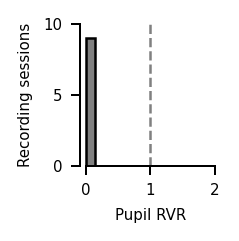

In [62]:
fig, ax = plt.subplots()

pupil_snr = df['natmov_snr_pupil']
ax.hist(pupil_snr, bins=np.linspace(0, 2, 15), lw=1, fc='gray', ec='black')
ax.axvline(1, ls='--', lw=1, color='gray')

ax.set_xticks([0, 1, 2])
ax.set_xlabel('Pupil RVR')
ax.set_yticks([0, 5, 10])
ax.set_ylabel('Recording sessions')

clip_axes_to_ticks(ax=ax)
set_plotsize(w=2, h=2)

fig.savefig(FIGUREPATH + 'natmov_rvr_pupil.svg')

In [63]:
# Raw data needed for full 200 trial example because normally 'pupil' dataframes 
# from fetch_data only store the longest continuous segment of data
df_example = pd.read_pickle(DATAPATH + '/pupil_fig5Aexample.pkl')
df_example = pd.merge(df_trials, df_example).set_index(['m', 's', 'e'])

kwargs = {'pre':-1, 'post':6, 'dt':0.01, 'bw':0.05, 'baseline':[-1, 0]}
df_example['natmov_pupil_response'] = df_example.apply(apply_get_responses, events='trial_on', data='pupil_area', post=5, axis='columns')

/tmp/ipykernel_53393/1454789840.py:4: RuntimeWarning: Mean of empty slice
  noise = np.nanmean(pupil_raster, axis=1)


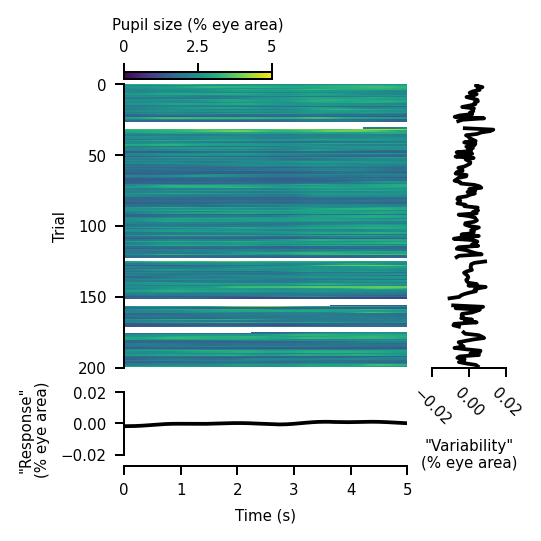

In [64]:
idx = key2idx(FIG5AEXAMPLEKEY)[:-1]
pupil_raster = df_example.loc[idx]['natmov_pupil_response']
signal = np.nanmean(pupil_raster, axis=0)
noise = np.nanmean(pupil_raster, axis=1)
n_trials = len(pupil_raster)

fig, ax = plt.subplots()

mat = ax.matshow(pupil_raster, vmin=0.0, vmax=0.05, aspect='auto')
ax.set_xlim([0, pupil_raster.shape[1]])
ax.xaxis.set_visible(False)
ax.set_yticks(np.arange(0, n_trials + 1, 50))
ax.set_ylim([n_trials, 0])
ax.set_ylabel('Trial')
clip_axes_to_ticks(ax=ax, spines=['left'])

fig.subplots_adjust(bottom=0.3, right=0.7)
bbox = ax.get_position()

cax = fig.add_axes([bbox.x0, bbox.y1 + 0.01, 0.3, 0.015])
cbar = plt.colorbar(mat, cax=cax, orientation='horizontal', label='Pupil size (% eye area)')
cbar.set_ticks([0, 0.025, 0.05])
cbar.set_ticklabels([0, 2.5, 5])
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

ax_psth = fig.add_axes([bbox.x0, bbox.y0 - 0.2, bbox.width, 0.15])
ax_psth.plot(np.linspace(0, 5, len(signal)), signal - signal.mean(), color='black')
ax_psth.set_xlim([0, 5])
ax_psth.set_xlabel('Time (s)')
ax_psth.set_yticks([-0.02, 0, 0.02])
ax_psth.set_ylim(bottom=-0.027)
ax_psth.set_ylabel('"Response"\n(% eye area)')
clip_axes_to_ticks(ax=ax_psth)

ax_noise = fig.add_axes([bbox.x1 + 0.05, bbox.y0, 0.15, bbox.height])

ax_noise.plot(noise - np.nanmean(noise), np.arange(n_trials), color='black')
ax_noise.set_xlabel('"Variability"\n(% eye area)')
ax_noise.yaxis.set_visible(False)
ax_noise.invert_yaxis()
ax_noise.set_ylim([pupil_raster.shape[0], 0])
ax_noise.set_xticks([-0.02, 0, 0.02])
plt.xticks(rotation=315)
clip_axes_to_ticks(ax=ax_noise, spines=['bottom'])

set_plotsize(w=4, h=4)
fig.savefig(FIGUREPATH + 'natmov_pupilraster.svg')

In [65]:
df = load_data('phasetuning', ['spontaneous', 'sparsenoise'])
df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
df['burst_sig'] = df['burst_p'] <= 0.05
df['freq_bin'] = np.digitize(df['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1)

df_natmov = load_data('phasetuning', ['natmov', 'natmov_opto'], subsample='noopto')
df_natmov['tonicspk_sig'] = df_natmov['tonicspk_p'] <= 0.05
df_natmov['burst_sig'] = df_natmov['burst_p'] <= 0.05
df_natmov['freq_bin'] = np.digitize(df_natmov['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1)
coupling_summary(df_natmov)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl
Loading:  phasetuning_natmov_noopto.pkl
Loading:  phasetuning_natmov_opto_noopto.pkl
Neurons with significant coupling: 0.984 (62/63)
Tonicspk prop. significant: 0.984 (62/63)
Tonicspk num. CPDs per neuron: 4.33, 1.67
Burst prop. significant: 0.627 (32/51)
Burst num. CPDs per neuron: 1.33, 1.37


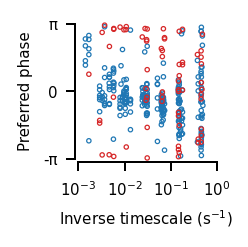

In [66]:
fig, ax = plt.subplots()

ax = phase_coupling_scatter(df_natmov, ax=ax)
set_plotsize(w=2, h=2)
clip_axes_to_ticks(ax=ax)

fig.savefig(FIGUREPATH + 'phase_coupling_scatter_natmov.svg')

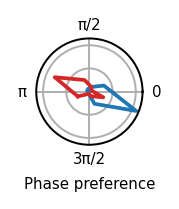

In [70]:
bins = np.linspace(-np.pi, np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})
for event in ['tonicspk', 'burst']:
    natmov_phases = df_natmov.query(f'(freq_bin <= 4) & ({event}_sig == True)')[f'{event}_phase']
    _, _ = plot_circhist(natmov_phases, bins=bins, ax=ax, color=COLORS[event])

ax.set_xlabel(r'Phase preference')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_pref_circhist_natmov_lowfreq.svg')

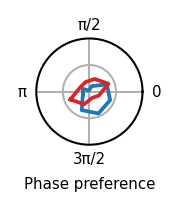

In [71]:
bins = np.linspace(-np.pi, np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})
for event in ['tonicspk', 'burst']:
    natmov_phases = df_natmov.query(f'(freq_bin > 4) & ({event}_sig == True)')[f'{event}_phase']
    _, _ = plot_circhist(natmov_phases, bins=bins, ax=ax, color=COLORS[event])

ax.set_xlabel(r'Phase preference')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_pref_circhist_natmov_highfreq.svg')

V 1.598e+01, p 1.263e-03
Natmov mean: 2.845729669435725


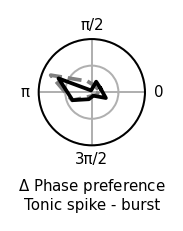

In [72]:
bins = np.linspace(0, 2 * np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})

df_sig = df.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff = (df_sig['tonicspk_phase'] - df_sig['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff, bins=bins, ax=ax, color='gray', ls='--')

df_sig_natmov = df_natmov.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_natmov = (df_sig_natmov['tonicspk_phase'] - df_sig_natmov['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_natmov, bins=bins, ax=ax, color='black')

ax.set_xlabel(r'$\Delta$ Phase preference' + '\nTonic spike - burst')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])
# ax.set_ylim(top=0.5)

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_diff_circhist_natmov.svg')

N = len(phase_diff_natmov)
p, v = vtest(phase_diff_natmov, np.pi)
print(f'V {v:.3e}, p {p:.3e}')
print(f'Natmov mean: {circmean_angle(phase_diff_natmov)}')

Tonicspk median: 0.0081, N: 682
Tonicspk natmov median: 0.0050, N: 273
MannwhitneyuResult(statistic=105686.0, pvalue=0.0010768389702425123)
Burst median: 0.0528, N: 320
Burst natmov median: 0.0332, N: 68
MannwhitneyuResult(statistic=12063.0, pvalue=0.15914559366740322)


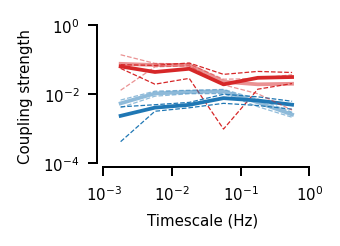

In [73]:
fig, ax = plt.subplots()
ax = coupling_strength_line_plot(df_natmov, agg=np.median, err=se_median, ax=ax)
ax = coupling_strength_line_plot(df, agg=np.median, err=se_median, ax=ax, alpha=0.5)

yticks = [-4, -2, 0]
ax.set_yticks(yticks)
ax.set_yticklabels(['10$^{%d}$' % tick for tick in yticks])
ax.set_ylim(bottom=-4.1)

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'coupling_strength_natmov.svg')

for spk_type in ['tonicspk', 'burst']:
    strengths = df.query(f'{spk_type}_sig == True')[f'{spk_type}_strength']
    strengths_natmov = df_natmov.query(f'{spk_type}_sig == True')[f'{spk_type}_strength']
    print(f'{spk_type.capitalize()} median: {strengths.median():.4f}, N: {len(strengths)}')
    print(f'{spk_type.capitalize()} natmov median: {strengths_natmov.median():.4f}, N: {len(strengths_natmov)}')
    print(mannwhitneyu(strengths, strengths_natmov))

### Figure 5D
Stimulus decoding across phase bins.

In [74]:
conditions = ['natmov', 'natmov_opto']

df_decoding = load_data('imfdecoding', conditions)
df_decoding.rename({'tonicspk_phase':'tonicspk_score', 'burst_phase':'burst_score'}, inplace=True, axis='columns')
df_tuning = load_data('phasetuning', conditions, tranges='noopto')

df = pd.merge(df_decoding, df_tuning).set_index(['m', 's', 'e', 'u', 'imf'])
df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
df['burst_sig'] = df['burst_p'] <= 0.05

Loading:  imfdecoding_natmov.pkl
Loading:  imfdecoding_natmov_opto.pkl
Loading:  phasetuning_natmov_noopto.pkl
Loading:  phasetuning_natmov_opto_noopto.pkl


0.99609375 399
0.9960238568588469 399


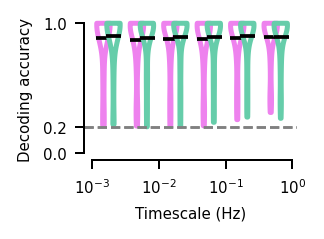

In [75]:
fig, ax = plt.subplots()

positions = np.log10(FREQUENCYBINS[:-1]) + 0.25
xoffset = 0.075
for phasebin in [1, 2]:
    scores = sort_data(df['stim_train%d_test%d' % (phasebin, phasebin)], df['freq'], bins=FREQUENCYBINS)
    violins = ax.violinplot(scores, positions - xoffset, widths=0.2, showextrema=False)
    for violin in violins['bodies']:
        violin.set_facecolor('none')
        violin.set_edgecolor(COLORS['phasebin%d' % phasebin])
        violin.set_linewidth(2)
        violin.set_alpha(1)
    ax.scatter(positions - xoffset, [s.mean() for s in scores], marker='_', color='black')
    ax.axhline(0.2, ls='--', lw=1, color='gray')
    
    xoffset *= -1
    
    print(np.median(np.concatenate(scores)), len(np.concatenate(scores)))

ax.set_xticks(FREQUENCYTICKS)
ax.set_xticklabels(FREQUENCYTICKLABELS)
ax.set_xlim(left=-3.11)
ax.set_xlabel('Timescale (Hz)')
ax.set_yticks([0, 0.2, 1])
ax.set_ylim(bottom=-0.05)
ax.set_ylabel('Decoding accuracy')

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)

fig.savefig(FIGUREPATH + 'stimulus_decoding.svg')

In [76]:
for pbin in [1, 2]:
    if pbin == 1:
        df['train%d_diff' % pbin] = df['stim_train%d_test2' % pbin] - df['stim_train%d_test%d' % (pbin, pbin)]
    elif pbin == 2:
        df['train%d_diff' % pbin] = df['stim_train%d_test1' % pbin] - df['stim_train%d_test%d' % (pbin, pbin)]
    df['train%d_rank' % pbin] = df.apply(lambda x: 10 - x['stim_testshf'].searchsorted(x['train%d_diff' % pbin]), axis='columns')
    df['train%d_sig' % pbin] = df.apply(lambda x: x['train%d_rank' % pbin] >= 10, axis='columns')

Phasebin 1: rank >= 10 in 54/63 units
Phasebin 2: rank >= 10 in 57/63 units


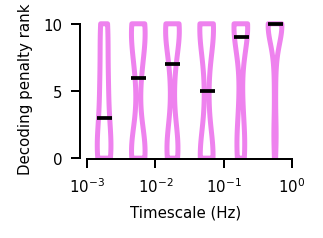

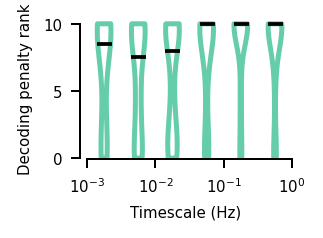

In [77]:
positions = np.log10(FREQUENCYBINS[:-1]) + 0.25
for phasebin in [1, 2]:
    fig, ax = plt.subplots()

    rank10 = df.groupby(['m', 's', 'e', 'u']).apply(lambda x: (x[f'train{phasebin}_rank'] == 10).any())
    print(f'Phasebin {phasebin}: rank >= 10 in {rank10.sum()}/{len(rank10)} units')
    
    ranks = sort_data(df['train%d_rank' % phasebin], df['freq'], bins=FREQUENCYBINS)
    violins = ax.violinplot(ranks, positions, widths=0.2, showextrema=False)
    for violin in violins['bodies']:
        violin.set_facecolor('none')
        violin.set_edgecolor(COLORS['phasebin%d' % phasebin])
        violin.set_linewidth(2)
        violin.set_alpha(1)
    ax.scatter(positions, [np.median(r) for r in ranks], marker='_', color='black')
    
    ax.set_xticks(FREQUENCYTICKS)
    ax.set_xticklabels(FREQUENCYTICKLABELS)
    ax.set_xlim(left=-3.11)
    ax.set_xlabel('Timescale (Hz)')
    ax.set_yticks([0, 5, 10])
    ax.set_ylim(bottom=-0.05)
    ax.set_ylabel('Decoding penalty rank')

    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=3, h=2)
    
    fig.savefig(FIGUREPATH + 'stimulus_decoding_ranks%d.svg' % phasebin)

-0.33605152277351447
-0.3448659864844835


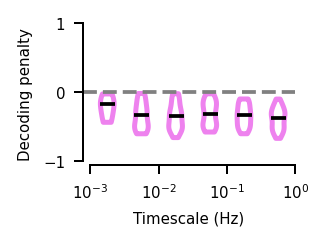

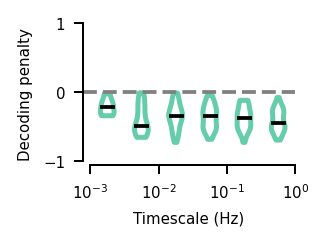

In [78]:
positions = np.log10(FREQUENCYBINS[:-1]) + 0.25
for phasebin in [1, 2]:
    fig, ax = plt.subplots()
    
    df_sig = df.query('train%d_sig' % phasebin)
    penalties = sort_data(df_sig['train%d_diff' % phasebin], df_sig['freq'], bins=FREQUENCYBINS)
    violins = ax.violinplot(penalties, positions, widths=0.2, showextrema=False)
    for violin in violins['bodies']:
        violin.set_facecolor('none')
        violin.set_edgecolor(COLORS['phasebin%d' % phasebin])
        violin.set_linewidth(2)
        violin.set_alpha(1)
    ax.scatter(positions, [np.median(p) for p in penalties], marker='_', color='black')

    print(np.median(np.concatenate(penalties)))
    
    ax.axhline(0, ls='--', color='gray')
    
    ax.set_xticks(FREQUENCYTICKS)
    ax.set_xticklabels(FREQUENCYTICKLABELS)
    ax.set_xlim(left=-3.11)
    ax.set_xlabel('Timescale (Hz)')
    ax.set_yticks([-1, 0, 1])
    ax.set_ylim(bottom=-1.05)
    ax.set_ylabel('Decoding penalty')

    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=3, h=2)
    
    fig.savefig(FIGUREPATH + 'stimulus_decoding_penalties%d.svg' % phasebin)